<a id=top></a>

# Курсовой проект от Megafon
**Курс:** Geekbrains Видеокурс от Megafon + курсовой проект
**Факультет:** Искусственный интелект  
**Группа:** GU_AI_1445 (24.05.2021)  
**Студент:** Гусев Александр Владимирович

## Оглавление:

* [Постановка задачи](#target_setting)
* [Подключение библиотек и скриптов](#load_libs_scripts)
* [Загрузка исходных данных](#load_data)
    * [Пути к директориям и файлам](#path_data)
    * [Загрузка данных](#load_dataset)
* [Обзор данных](#data_overview)
    * [Обзор целевой переменной](#target_feature_overview)    
* [Анализ данных (Exploratory Data Analysis (EDA))](#eda)
    * [Определение типа признаков](#feature_type)    
* [Предварительная обработка данных](#memory_optimizing_pipeline)
    * [Pipeline добавления признаков](#feature_add_pipeline)
    * [Pipeline оптимизации памяти](#data_preprocessing)
    * [Pipeline обработки признаков](#feature_processing_pipeline)
* [Построение моделей](#modeling) 
    * [Отбор признаков](#feature_selection)
    * [Балансировка классов](#classes_balancing)
    * [Обучение модели](#model_fit)
    * [Подбор гиперпараметров](#tuning_model)
    * [Построение финальной модели](#final_model)
    * [Выбор порога вероятности для определения класса](#threshold_calibration)
    * [Важность признаков](#feature_importances)
    * [Сравнение моделей](#comparison_of_models)
    * [Сохранение финальной модели](#final_model_saving)
* [Прогнозирование на тестовом датасете](#forecasting)

## Постановка задачи<a class="anchor" id="target setting"></a>

В качестве исходных данных вам будет доступна информация об отклике абонентов на предложение подключения одной из услуг. Каждому пользователю может быть сделано несколько предложений в разное время, каждое из которых он может или принять, или отклонить.
Отдельным набором данных будет являться нормализованный анонимизированный набор признаков, характеризующий профиль потребления абонента. Эти данные привязаны к определенному времени, поскольку профиль абонента может меняться с течением времени.
Данные train и test разбиты по периодам – на train доступно 4 месяцев, а на test отложен последующий месяц. 
Итого, в качестве входных данных будут представлены:  
* data_train.csv: id, vas_id, buy_time, target  
* features.csv.zip: id, <feature_list>  
* data_test.csv: id, vas_id, buy_time  

**target** - целевая переменная, где 1 означает подключение услуги, 0 - абонент не подключил услугу соответственно.   
**buy_time** - время покупки, представлено в формате timestamp, для работы с этим столбцом понадобится функция datetime.fromtimestamp из модуля datetime.  
**id** - идентификатор абонента  
**vas_id** - подключаемая услуга  


Метрика
Скоринг будет осуществляться функцией f1, невзвешенным образом, как например делает функция sklearn.metrics.f1_score(…, average=’macro’).
 sklearn.metrics.f1_score — scikit-learn 0.22.1 documentation





Формат представления результата  
    1. Работающая модель в формате pickle, которая принимает файл data_test.csv из корневой папки и записывает в эту же папку файл answers_test.csv. В этом файле должны находится 4 столбца: buy_time, id, vas_id и target. Target можно записать как вероятность подключения услуги.  
    2. Код модели можно представить в виде jupyter-ноутбука.   
    3. Презентация в формате .pdf, в которой необходимо отразить:  
        ◦ Информация о модели, ее параметрах, особенностях и основных результатах.  
        ◦ Обоснование выбора модели и ее сравнение с альтернативами.  
        ◦ Принцип составления индивидуальных предложений для выбранных абонентов.  
Рекомендуемое количество слайдов – 5 – 10.  
Файл answers_test.csv с результатами работы модели, презентацию, ноутбуки и резюме необходимо прикрепить ко второму уроку “курсовой проект”.



## Подключение библиотек и скриптов<a class="anchor" id="load_libs_scripts"></a>

In [1]:
# Libraries for working with paths and saving
from pathlib import Path
import os
import pickle

# Dask libraries
import dask.dataframe as dd
from dask.distributed import Client, LocalCluster

# Time libraries
import time
from datetime import datetime, timedelta

# Scientific libraries
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('seaborn')
sns.set(rc={'figure.figsize': (10,6)})
pd.options.display.float_format = '{:.3f}'.format


# Sklearn libraries
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectFromModel
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV

from imblearn.pipeline import Pipeline

# Other libraries
import random
import itertools


import warnings
warnings.filterwarnings("ignore")

In [2]:
# используемые глобальные переменные

TARGET='target'
RANDOM_STATE=42

In [3]:
def time_format(sec):
    return str(timedelta(seconds=sec))

In [4]:
def optimizing_dd(df, silent=False):    
    assert isinstance(df, dd.DataFrame), 'This is not a dask dataframe'
    start_t = time.time()
    
    if not silent:
        start_memory_usage = client.compute(df.memory_usage(deep=True).sum() / 1024**2)
        print('Start of dataframe memory optimization'.center(100,'*'))
        print(f'Memory usage by dataframe: {start_memory_usage.result():.02f} MB')
    
    df_dtype = pd.DataFrame(df.dtypes, columns=['dtype'], index = df.columns)
    
    df_min = client.compute(df.select_dtypes(['int', 'float']).min())
    df_max = client.compute(df.select_dtypes(['int', 'float']).max())
    df_is_int = client.compute(~(df.select_dtypes(['int', 'float']).fillna(0).astype(int).sum() - df.select_dtypes(['int', 'float']).fillna(0).sum()).astype('bool_'))
    
    df_dtype['min'] = df_min.result()
    df_dtype['max'] = df_max.result()
    df_dtype['is_int'] = df_is_int.result()
    
    df_dtype.loc[(df_dtype['is_int'] == True),'dtype'] = 'int64'
    df_dtype.loc[(df_dtype['is_int'] == True) & (df_dtype['min'] >= np.iinfo('int32').min) & (df_dtype['max'] <= np.iinfo('int32').max),'dtype'] = 'int32'
    df_dtype.loc[(df_dtype['is_int'] == True) & (df_dtype['min'] >= np.iinfo('int16').min) & (df_dtype['max'] <= np.iinfo('int16').max),'dtype'] = 'int16'
    df_dtype.loc[(df_dtype['is_int'] == True) & (df_dtype['min'] >= np.iinfo('int8').min) & (df_dtype['max'] <= np.iinfo('int8').max),'dtype'] = 'int8'
    
    df_dtype.loc[(df_dtype['is_int'] == True) & (df_dtype['min'] >= np.iinfo('uint64').min) ,'dtype'] = 'uint64'
    df_dtype.loc[(df_dtype['is_int'] == True) & (df_dtype['min'] >= np.iinfo('uint32').min) & (df_dtype['max'] <= np.iinfo('uint32').max),'dtype'] = 'uint32'
    df_dtype.loc[(df_dtype['is_int'] == True) & (df_dtype['min'] >= np.iinfo('uint16').min) & (df_dtype['max'] <= np.iinfo('uint16').max),'dtype'] = 'uint16'
    df_dtype.loc[(df_dtype['is_int'] == True) & (df_dtype['min'] >= np.iinfo('uint8').min) & (df_dtype['max'] <= np.iinfo('uint8').max),'dtype'] = 'uint8'
    
    df_dtype.loc[(df_dtype['is_int'] == True) & (df_dtype['min'] == 0) & (df_dtype['max'] == 1),'dtype'] = 'bool_'
    
    df_dtype.loc[(df_dtype['is_int'] == False), 'dtype'] = 'float64'
    df_dtype.loc[(df_dtype['is_int'] == False) & (df_dtype['min'] >= np.finfo('float32').min) & (df_dtype['max'] <= np.finfo('float32').max), 'dtype'] = 'float32'
    df_dtype.loc[(df_dtype['is_int'] == False) & (df_dtype['min'] >= np.finfo('float16').min) & (df_dtype['max'] <= np.finfo('float16').max), 'dtype'] = 'float16'
    
    for col in df.select_dtypes('object').columns:
        num_unique_values = client.compute(df[col].nunique())
        num_total_values = client.compute(df['id'].shape)
        if num_unique_values.result() / num_total_values[0].result() < 0.5:
            df_dtype.loc[col, 'dtype'] = 'category'
    
    dtypes = df_dtype['dtype'].to_dict()
    
    df = df.astype(dtypes)
    
    if not silent:
        memory_usage = client.compute(df.memory_usage(deep=True).sum() / 1024**2)
        print('MEMORY USAGE AFTER COMPLETION:'.center(40,'_'))
        print(f'Memory usage of properties dataframe is : {memory_usage.result():.02f} MB')
        print(f'This is {100*memory_usage.result()/start_memory_usage.result():.02f} % of the initial size')
        print(f'End of dataframe memory optimization, run time: {time_format(time.time()-start_t)}'.center(100,'*'))
    return df

## Загрузка исходных данных<a class="anchor" id="load_data"></a>

### Пути к директориям и файлам<a class="anchor" id="path_data"></a>

In [5]:
DATA_ROOT = Path('../')
MODELS_PATH = Path('../2_models/')

# input
TRAIN_DATASET_PATH = DATA_ROOT / '1_input_data/data_train.csv'
FEATURES_DATASET_PATH = DATA_ROOT / '1_input_data/features.csv'
TEST_DATASET_PATH = DATA_ROOT / '1_input_data/data_test.csv'

# output
DF_FEATURES_DATASET_PATH = DATA_ROOT / '1_input_data/features.pkl'
SUBMISSION_PATH = DATA_ROOT / 'answers_test.csv'
MODEL_FILE_PATH = MODELS_PATH / 'model.pkl'

### Загрузка данных<a class="anchor" id="load_dataset"></a>

In [6]:
df_train = pd.read_csv(TRAIN_DATASET_PATH, index_col=[1]).drop('Unnamed: 0', axis=1)
df_train.head()

,vas_id,buy_time,target
id,,,
540968,8.000,1537131600,0.000
1454121,4.000,1531688400,0.000
2458816,1.000,1534107600,0.000
3535012,5.000,1535922000,0.000
1693214,1.000,1535922000,0.000


In [7]:
df_train.shape

(831653, 3)

In [8]:
if os.path.exists(DF_FEATURES_DATASET_PATH):
    df_features = pd.read_pickle(DF_FEATURES_DATASET_PATH)

In [9]:
if not os.path.exists(DF_FEATURES_DATASET_PATH):    
    df = dd.read_csv(FEATURES_DATASET_PATH, sep='\t').drop('Unnamed: 0', axis=1)
    df = optimizing_dd(df)
    df = df.set_index('id')
    df_features = df.compute()
    df_features.to_pickle(DF_FEATURES_DATASET_PATH)

In [10]:
df_features

,buy_time,0,1,2,3,4,5,6,7,8,...,243,244,245,246,247,248,249,250,251,252
id,,,,,,,,,,,,,,,,,,,,,
0,1539550800,-87.480,-258.499,-93.791,-192.487,-99.208,-213.592,-16.086,-65.076,-6.784,...,-977.374,-613.771,-25.996,-37.625,-306.748,-25.833,-0.694,-12.176,-0.456,0
1,1546808400,-95.300,-47.949,-55.071,-42.147,-60.488,-63.252,-16.086,-65.076,-6.784,...,-952.374,-611.771,-25.996,-17.625,-250.748,-17.833,-0.694,-12.176,-0.456,0
2,1545598800,-96.800,229.531,-110.741,305.723,-116.158,284.618,-16.086,-65.076,-6.784,...,2300.626,1492.229,-21.996,-35.625,368.252,11.167,7.305,-12.176,-0.456,0
3,1544994000,-25.610,-275.969,-27.691,-287.057,-33.108,-308.162,-16.086,-65.076,-6.784,...,971.626,-613.771,-25.996,-37.625,-229.748,-19.833,-0.694,-12.176,-0.456,0
4,1538341200,-96.800,-323.429,-110.741,-376.037,-116.158,-397.142,-16.086,19.674,-6.784,...,4806.626,4140.229,-25.996,-37.625,-35.748,-20.833,-0.694,-7.176,-0.456,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4362735,1537736400,7.540,-28.709,-4.711,-79.627,-10.128,-100.732,-16.086,-65.076,-6.784,...,-977.374,-613.771,-24.996,-37.625,-263.748,-1.833,-0.694,11.824,-0.456,0
4362736,1541365200,-20.970,-120.619,-31.531,-166.457,-36.948,-187.562,-16.086,-60.936,-6.784,...,-977.374,-613.771,-24.996,-37.625,-306.748,-25.833,-0.694,-12.176,-0.456,1
4362737,1531083600,-96.800,269.791,-110.741,221.423,-116.158,200.318,-16.086,-65.076,-6.784,...,-940.374,-613.771,-25.996,-34.625,-209.748,7.167,-0.694,20.824,-0.456,1


## Обзор данных<a class="anchor" id="data_overview"></a>

In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 831653 entries, 540968 to 3022610
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   vas_id    831653 non-null  float64
 1   buy_time  831653 non-null  int64  
 2   target    831653 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 25.4 MB


In [12]:
print(f'Количество пропусков в датасете df_train: {df_train.isnull().sum().sum() / df_train.count().sum() * 100:.02f} % of total Values')

Количество пропусков в датасете df_train: 0.00 % of total Values


In [13]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
UInt64Index: 4512528 entries, 0 to 4362738
Columns: 254 entries, buy_time to 252
dtypes: float16(192), float32(55), uint16(1), uint32(1), uint8(5)
memory usage: 2.6 GB


In [14]:
print(f'Количество пропусков в датасете df_features: {df_features.isnull().sum().sum() / df_features.count().sum() * 100:.02f} % of total Values')

Количество пропусков в датасете df_features: 0.00 % of total Values


### Обзор целевой переменной<a class="anchor" id="target_feature_overview"></a>

In [15]:
df_train['target'].value_counts() 

0.000    771467
1.000     60186
Name: target, dtype: int64

In [16]:
df_train.count()[0]

831653

In [17]:
print(f'Целевая переменная имеет неравномерное распределение. Значение 0 составляет {(df_train["target"].value_counts()[0] / df_train.count()[0]) * 100:.02f}%, а значение 1 всего {(df_train["target"].value_counts()[1] / df_train.count()[0]) * 100:.02f}%.')

Целевая переменная имеет неравномерное распределение. Значение 0 составляет 92.76%, а значение 1 всего 7.24%.


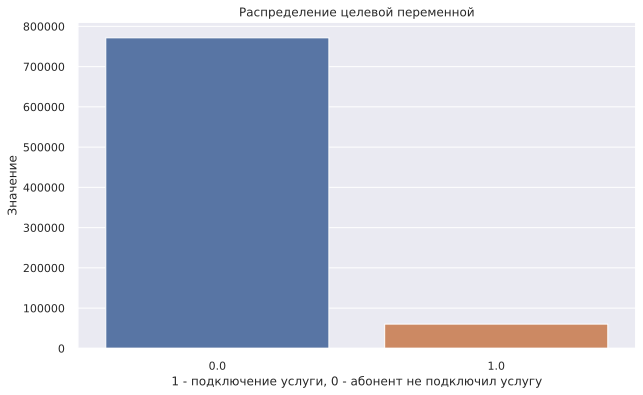

In [18]:
counts = df_train['target']. value_counts()

plt.title('Распределение целевой переменной')
sns.barplot(counts.index, counts.values)
plt.xlabel('1 - подключение услуги, 0 - абонент не подключил услугу')
plt.ylabel('Значение')
plt.show()

## Анализ данных (Exploratory Data Analysis (EDA))<a class="anchor" id="eda"></a>

In [19]:
# Разделим признаки и целевую переменную
data_prelim = df_train.copy()

X = data_prelim.drop(TARGET, axis=1)
y = data_prelim[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=RANDOM_STATE)

In [20]:
del(X)
del(y)

### Определение типа признаков<a class="anchor" id="feature_type"></a>

In [21]:
features_train = df_features[df_features.index.isin(X_train.index.unique())]

In [22]:
features_train = features_train.sort_values('buy_time')

In [23]:
features_train = features_train.groupby('id').last()

In [24]:
%%time

df_augmented = X_train.merge(features_train, left_index=True, right_index=True, how='left', suffixes=('_train', '_features'))

CPU times: user 6.46 s, sys: 2.67 s, total: 9.12 s
Wall time: 9.13 s


In [25]:
df_nunique = df_augmented.apply(lambda x: x.nunique(dropna=False))

In [26]:
df_nunique.shape

(256,)

In [27]:
df_nunique

vas_id                    8
buy_time_train           26
buy_time_features        29
0                     40087
1                    100076
                      ...  
248                    2007
249                     234
250                    1372
251                     212
252                      24
Length: 256, dtype: int64

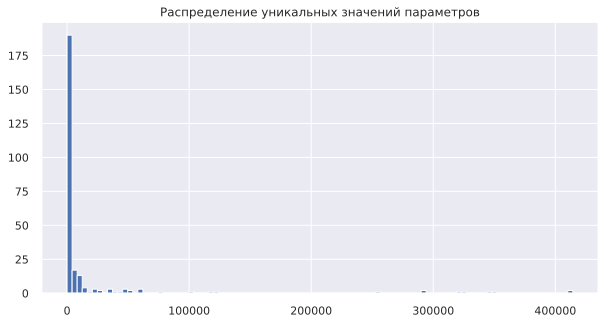

In [28]:
plt.title('Распределение уникальных значений параметров');
df_nunique.hist(bins=100, figsize=(10, 5));

In [29]:
f_all = set(df_nunique.index.tolist())
len(f_all)

256

#### Временные признаки

In [30]:
f_date = set(col for col in df_augmented.columns if 'time' in col)
len(f_date)

2

In [31]:
f_other = f_all - f_date
len(f_other)

254

#### Константные признаки

In [32]:
f_const = set(df_nunique[df_nunique == 1].index.tolist())
len(f_const)

5

In [33]:
f_other = f_other - f_const
len(f_other)

249

#### Вещественные признаки

In [34]:
f_numeric = (df_augmented.fillna(0).astype(int).sum() - df_augmented.fillna(0).sum()).abs()
f_numeric = set(f_numeric[f_numeric > 0].index.tolist())
len(f_numeric)

247

In [35]:
f_other = f_other - f_numeric
len(f_other)

2

#### Бинарные признаки

In [36]:
f_binary = set(df_augmented.loc[:, f_other].columns[(
                      (df_augmented.loc[:, f_other].max() == 1) & 
                      (df_augmented.loc[:, f_other].min() == 0) & 
                      (df_augmented.loc[:, f_other].isnull().sum() == 0))])
len(f_binary)

0

In [37]:
f_other = f_other - f_binary
len(f_other)

2

#### Категориальные признаки

In [38]:
f_categorical = set(df_nunique.loc[f_other][df_nunique.loc[f_other] <= 10].index.tolist())
len(f_categorical)

1

In [39]:
f_other = f_other - f_categorical
len(f_other)

1

#### Прочие признаки

In [40]:
f_numeric = f_numeric | f_other

In [41]:
f_other = f_other - f_numeric
len(f_other)

0

Проверим, что мы ничего не забыли

In [42]:
assert(df_nunique.shape[0] == len(f_date) + len(f_const) + len(f_binary) + len(f_numeric) + len(f_categorical)), "Пропущен признак"

In [43]:
print(f'Всего признаков: {df_augmented.shape[1]}\n')
print(f'Временных признаков: {len(f_date)}')
print(f'Константных признаков: {len(f_const)}')
print(f'Бинарных признаков: {len(f_binary)}')
print(f'Категориальных признаков: {len(f_categorical)}')
print(f'Вещественных признаков: {len(f_numeric)}')

f_ok = list(X_train.columns)

f_date = list(f_date)
f_binary = list(f_binary)
f_categorical = list(f_categorical)
f_numeric = list(f_numeric)

Всего признаков: 256

Временных признаков: 2
Константных признаков: 5
Бинарных признаков: 0
Категориальных признаков: 1
Вещественных признаков: 248


In [44]:
del(features_train)
del(df_augmented)

## Предварительная обработка данных<a class="anchor" id="data_preprocessing"></a>

### Pipeline добавления признаков<a class="anchor" id="feature_add_pipeline"></a>

In [45]:
class AddFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, features, silent=True):
        self.features = features
        self.silent = silent
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if not self.silent:
            start_t = time.time()
            print('Start adding features'.center(100,'*'))
        assert isinstance(X, pd.DataFrame), 'This is not a pandas dataframe'
              
        X_features = self.features.loc[self.features.index.isin(X.index.unique())]

        X_features = X_features.sort_values('buy_time').groupby('id').last()

        X_merge = X.reset_index().merge(X_features.reset_index(),  on=X.index.name, how='left', suffixes=('_train', '_features')) \
                    .set_index(X.index.name)
          
        assert X_merge.shape[0] == X.shape[0], f'Shapes of dataframe don\'t match: {X_merge.shape[0]} and {X.shape[0]}'
        assert (X_merge.index == X.index).all(), 'Index Sort Error'
        if not self.silent:
            print(f'End adding features, run time: {time_format(time.time()-start_t)}'.center(100,'*'))
            print()
            
        return X_merge

In [46]:
class GetDate(BaseEstimator, TransformerMixin):
    def __init__(self, silent=True):
        self.silent = silent
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if not self.silent:
            start_t = time.time()
            print('Start geting date from timestamp'.center(100,'*'))
        if isinstance(X, pd.Series):
            X = pd.DataFrame(X)

        assert isinstance(X, pd.DataFrame), 'This is not a pandas dataframe or series'
        
        df = pd.DataFrame()
        
        for col in X.columns:
            df[f'{col}_day'] = pd.to_datetime(X[col], unit='s').dt.day
            df[f'{col}_month'] = pd.to_datetime(X[col], unit='s').dt.month
            df[f'{col}_week'] = pd.to_datetime(X[col], unit='s').dt.week
            
            # добавить ещё параметров
            
        if not self.silent:
            print(f'End geting date from timestamp, run time: {time_format(time.time()-start_t)}'.center(100,'*'))
            print()
        return df

### Pipeline оптимизации памяти<a class="anchor" id="memory_optimizing_pipeline"></a>

In [47]:
class MemUseOptimizing(BaseEstimator, TransformerMixin):
    def __init__(self, silent=True):
        self.silent = silent

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        start_t = time.time()
        
        assert isinstance(X, pd.DataFrame), 'This is not a pandas dataframe'
    
        if not self.silent:
            print('Start of dataframe memory use optimizing'.center(100,'*'))
            start_memory_usage = X.memory_usage(deep=True).sum() / 1024**2 
            
        
            X_dtype = pd.DataFrame(X.dtypes, columns=['dtype'], index = X.columns)                
            
            X_dtype['min'] = X.select_dtypes(['int', 'float']).min()
            X_dtype['max'] = X.select_dtypes(['int', 'float']).max()
            X_dtype['is_int'] = ~(X.select_dtypes(['int', 'float']).astype(int).sum() - X.select_dtypes(['int', 'float']).sum()).astype('bool_')
            
            X_dtype.loc[(X_dtype['is_int'] == True),'dtype'] = 'int64'
            X_dtype.loc[(X_dtype['is_int'] == True) & (X_dtype['min'] >= np.iinfo('int32').min) & (X_dtype['max'] <= np.iinfo('int32').max),'dtype'] = 'int32'
            X_dtype.loc[(X_dtype['is_int'] == True) & (X_dtype['min'] >= np.iinfo('int16').min) & (X_dtype['max'] <= np.iinfo('int16').max),'dtype'] = 'int16'
            X_dtype.loc[(X_dtype['is_int'] == True) & (X_dtype['min'] >= np.iinfo('int8').min) & (X_dtype['max'] <= np.iinfo('int8').max),'dtype'] = 'int8'
            
            X_dtype.loc[(X_dtype['is_int'] == True) & (X_dtype['min'] >= np.iinfo('uint64').min) ,'dtype'] = 'uint64'
            X_dtype.loc[(X_dtype['is_int'] == True) & (X_dtype['min'] >= np.iinfo('uint32').min) & (X_dtype['max'] <= np.iinfo('uint32').max),'dtype'] = 'uint32'
            X_dtype.loc[(X_dtype['is_int'] == True) & (X_dtype['min'] >= np.iinfo('uint16').min) & (X_dtype['max'] <= np.iinfo('uint16').max),'dtype'] = 'uint16'
            X_dtype.loc[(X_dtype['is_int'] == True) & (X_dtype['min'] >= np.iinfo('uint8').min) & (X_dtype['max'] <= np.iinfo('uint8').max),'dtype'] = 'uint8'
            
            X_dtype.loc[(X_dtype['is_int'] == True) & (X_dtype['min'] == 0) & (X_dtype['max'] == 1),'dtype'] = 'bool_'
            
            X_dtype.loc[(X_dtype['is_int'] == False), 'dtype'] = 'float64'
            X_dtype.loc[(X_dtype['is_int'] == False) & (X_dtype['min'] >= np.finfo('float32').min) & (X_dtype['max'] <= np.finfo('float32').max), 'dtype'] = 'float32'
            X_dtype.loc[(X_dtype['is_int'] == False) & (X_dtype['min'] >= np.finfo('float16').min) & (X_dtype['max'] <= np.finfo('float16').max), 'dtype'] = 'float16'
            
            for col in X.select_dtypes('object').columns:
                num_unique_values = len(X[col].unique())
                num_total_values = len(X[col])
                if num_unique_values / num_total_values < 0.5:
                    X_dtype.loc[col, 'dtype'] = 'category'
                    
            dtype = X_dtype['dtype'].to_dict()
                   
            X = X.astype(dtype)
            
        if not self.silent:
            memory_usage = X.memory_usage(deep=True).sum() / 1024**2
            print('Memory use optimizing'.center(100,'*'))
            print(f'Memory usage of properties dataframe before optimizing: {start_memory_usage:.02f} MB')
            print(f'Memory usage of properties dataframe after optimizing: {memory_usage:.02f} MB')      
            print(f'This is {100*memory_usage/start_memory_usage:.02f} % of the initial size')
            print(f'End of dataframe memory use optimizing, run time: {time_format(time.time()-start_t)}'.center(64,'*'))
            print()
                
        return X

### Pipeline обработки признаков<a class="anchor" id="feature_processing_pipeline"></a>

In [48]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)

        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError("DataFrame не содердит следующие колонки: %s" % cols_error)

In [49]:
feature_union_pipeline = FeatureUnion(transformer_list=[
                        ('date_features', make_pipeline(
                            ColumnSelector(f_date),
                            GetDate(),
                            StandardScaler()
                        )),
                        ('numeric_features', make_pipeline(
                            ColumnSelector(f_numeric),
                            SimpleImputer(strategy='constant', fill_value=0),
                            StandardScaler(),
                        )),
                        ('categorical_features', make_pipeline(
                            ColumnSelector(f_categorical),
                            SimpleImputer(strategy='most_frequent'),
                            OneHotEncoder(handle_unknown='ignore', sparse=False)
                        )),
                        ('boolean_features', make_pipeline(
                            ColumnSelector(f_binary),
                        ))
])

In [50]:
f_prep_pipeline = make_pipeline(
    ColumnSelector(columns=f_ok),
    AddFeatures(df_features),
    MemUseOptimizing(),
    feature_union_pipeline
)

In [51]:
f_prep_pipeline.steps

[('columnselector', ColumnSelector(columns=['vas_id', 'buy_time'])),
 ('addfeatures',
  AddFeatures(features=           buy_time       0        1        2        3        4        5  \
  id                                                                         
  0        1539550800 -87.480 -258.499  -93.791 -192.487  -99.208 -213.592   
  1        1546808400 -95.300  -47.949  -55.071  -42.147  -60.488  -63.252   
  2        1545598800 -96.800  229.531 -110.741  305.723 -116.158  284.618   
  3        1544994000 -25.610 -275.969  -27.691 -287.057  -33.108 -308.162   
  4        1538341200 -96.800 -323.429 -110.741 -376.037 -116.158 -397.142   
  ...             ...     ...      ...      ...      ...      ...      ...   
  4362735  153...
  2        368.252  11.167  7.305 -12.176 -0.456    0  
  3       -229.748 -19.833 -0.694 -12.176 -0.456    0  
  4        -35.748 -20.833 -0.694  -7.176 -0.456    0  
  ...          ...     ...    ...     ...    ...  ...  
  4362735 -263.748  -1.833 

In [52]:
X_test.shape[1]

2

In [53]:
# n_features = f_prep_pipeline.fit_transform(X_test).shape
# n_features

In [54]:
f_prep_pipeline.fit(X_train)

n_features = f_prep_pipeline.transform(X_test).shape[1]
n_features

262

## Построение моделей<a class="anchor" id="modeling"></a> 

In [55]:
def get_classification_report(models_list, X_train, y_train, 
                                        X_test, y_test, 
                                        classes,
                                        title='',
                                        threshold=0.5):
    
    for model_name, model in models_list.items():
        print()
        y_train_pred = model.predict_proba(X_train)[:,1]
        y_test_pred = model.predict_proba(X_test)[:,1]
        
        y_train_pred = y_train_pred > threshold
        y_test_pred = y_test_pred > threshold
        
        print(f'{model_name}. {title}'.center(53, '*'))
        print('TRAIN\n\n' + classification_report(y_train, y_train_pred))
        print('TEST\n\n' + classification_report(y_test, y_test_pred))
        plt.figure(figsize=(7, 4))
        plot_confusion_matrix(y_test, y_test_pred, classes=classes, title=f'Confusion matrix.\n {model_name}. {title}')
        plt.show()
        print('_'*53)
        print('\n')

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    cm = confusion_matrix(y_true, y_pred)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.grid(False)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes, rotation=90)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment='center', fontsize=16,
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    #filename = title.replace("\n","") + '.png'
    #plt.savefig(filename, format='png', dpi=300)
    
def plot_roc_pr(models_list, X_train, y_train, X_test, y_test, title='', threshold=0.5):

    f, (ax1, ax2) = plt.subplots(2, 1, sharey=True)
    
    f.set_figheight(10)
    f.set_figwidth(20)
    
    ax1 = plt.subplot(121)
    ax1.set_title(f'ROC. {title}')
    ax1.set_xlabel('TPR')
    ax1.set_ylabel('FPR')
    ax1.set_aspect('equal')
    ax1.plot([0, 1], [0, 1], 'k--')
    
    ax2 = plt.subplot(122)
    ax2.set_title(f'PR. {title}')
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_aspect('equal')
    
    f_scores = np.linspace(0.2, 0.8, num=4)
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
        ax2.annotate(f'f1={f_score:0.1f}', xy=(0.9, y[45] + 0.02), fontsize=14)
        
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    
    for model_name, model in models_list.items():
        y_pred_proba = model.predict_proba(X_test)[:,1]
        y_pred = y_pred_proba > threshold
        
        fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_proba)
        precision, recall, pr_thresholds = precision_recall_curve(y_test, y_pred_proba)
        
        ax1.plot(fpr, tpr, label=f'{model_name} (AUC={auc(fpr, tpr):.2f})')       
        ax2.plot(recall, precision, label=f'{model_name} (f1={f1_score(y_test, y_pred):.2f})')

    ax1.legend(loc="lower right")
    ax2.legend(loc="lower left")
    
    #filename = title.replace('\n', '') + '_ROC_PF.png'
    #plt.savefig(filename, format='png', dpi=300)
    
    plt.show()
    
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(1, 1))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))
    
    #plt.savefig('show_proba_calibration_plots.png', format='png', dpi=300)
    plt.show()

In [56]:
models_list = {
    'Logistic Regression': LogisticRegression(random_state=RANDOM_STATE, n_jobs=-1),
    'Random Forest Classifier': RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1),
    'XGBoost': XGBClassifier(random_state=RANDOM_STATE, n_jobs=-1),
    'LightGBM': LGBMClassifier(random_state=RANDOM_STATE),
    'CatBoost': CatBoostClassifier(random_state=RANDOM_STATE, logging_level='Silent'),
}

In [57]:
for model_name, model in models_list.items():
    start_t = time.time()
    print(f'Start fit {model_name}'.center(100,'*'))
    model.fit(X_train, y_train)
    print(f'End fit {model_name}, run time: {time_format(time.time()-start_t)}'.center(100,'*'))
    print()

***********************************Start fit Logistic Regression************************************
***********************End fit Logistic Regression, run time: 0:00:01.465058************************

*********************************Start fit Random Forest Classifier*********************************
*********************End fit Random Forest Classifier, run time: 0:00:06.598044*********************

*****************************************Start fit XGBoost******************************************
*****************************End fit XGBoost, run time: 0:00:06.151284******************************

*****************************************Start fit LightGBM*****************************************
*****************************End fit LightGBM, run time: 0:00:00.763686*****************************

*****************************************Start fit CatBoost*****************************************
*****************************End fit CatBoost, run time: 0:00:25.868909****************


************Logistic Regression. Baseline************
TRAIN

              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96    540047
         1.0       0.00      0.00      0.00     42110

    accuracy                           0.93    582157
   macro avg       0.46      0.50      0.48    582157
weighted avg       0.86      0.93      0.89    582157

TEST

              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96    231420
         1.0       0.00      0.00      0.00     18076

    accuracy                           0.93    249496
   macro avg       0.46      0.50      0.48    249496
weighted avg       0.86      0.93      0.89    249496



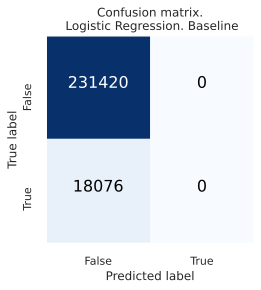

_____________________________________________________



**********Random Forest Classifier. Baseline*********
TRAIN

              precision    recall  f1-score   support

         0.0       0.94      0.99      0.97    540047
         1.0       0.70      0.24      0.35     42110

    accuracy                           0.94    582157
   macro avg       0.82      0.61      0.66    582157
weighted avg       0.93      0.94      0.92    582157

TEST

              precision    recall  f1-score   support

         0.0       0.94      0.99      0.97    231420
         1.0       0.71      0.23      0.35     18076

    accuracy                           0.94    249496
   macro avg       0.82      0.61      0.66    249496
weighted avg       0.93      0.94      0.92    249496



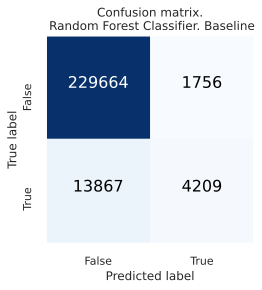

_____________________________________________________



******************XGBoost. Baseline******************
TRAIN

              precision    recall  f1-score   support

         0.0       0.94      0.99      0.97    540047
         1.0       0.70      0.24      0.35     42110

    accuracy                           0.94    582157
   macro avg       0.82      0.61      0.66    582157
weighted avg       0.93      0.94      0.92    582157

TEST

              precision    recall  f1-score   support

         0.0       0.94      0.99      0.97    231420
         1.0       0.71      0.23      0.35     18076

    accuracy                           0.94    249496
   macro avg       0.82      0.61      0.66    249496
weighted avg       0.93      0.94      0.92    249496



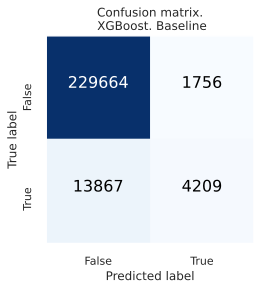

_____________________________________________________



******************LightGBM. Baseline*****************
TRAIN

              precision    recall  f1-score   support

         0.0       0.94      0.99      0.97    540047
         1.0       0.70      0.24      0.35     42110

    accuracy                           0.94    582157
   macro avg       0.82      0.61      0.66    582157
weighted avg       0.93      0.94      0.92    582157

TEST

              precision    recall  f1-score   support

         0.0       0.94      0.99      0.97    231420
         1.0       0.71      0.23      0.35     18076

    accuracy                           0.94    249496
   macro avg       0.82      0.61      0.66    249496
weighted avg       0.93      0.94      0.92    249496



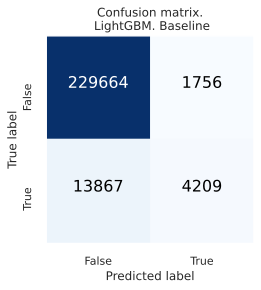

_____________________________________________________



******************CatBoost. Baseline*****************
TRAIN

              precision    recall  f1-score   support

         0.0       0.94      0.99      0.97    540047
         1.0       0.70      0.24      0.35     42110

    accuracy                           0.94    582157
   macro avg       0.82      0.61      0.66    582157
weighted avg       0.93      0.94      0.92    582157

TEST

              precision    recall  f1-score   support

         0.0       0.94      0.99      0.97    231420
         1.0       0.71      0.23      0.35     18076

    accuracy                           0.94    249496
   macro avg       0.82      0.61      0.66    249496
weighted avg       0.93      0.94      0.92    249496



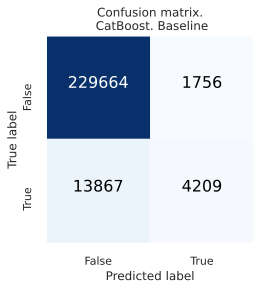

_____________________________________________________




In [58]:
get_classification_report(
                        models_list,
                        X_train, y_train, X_test, y_test,
                        classes=['False', 'True'], 
                        title='Baseline'
                             )

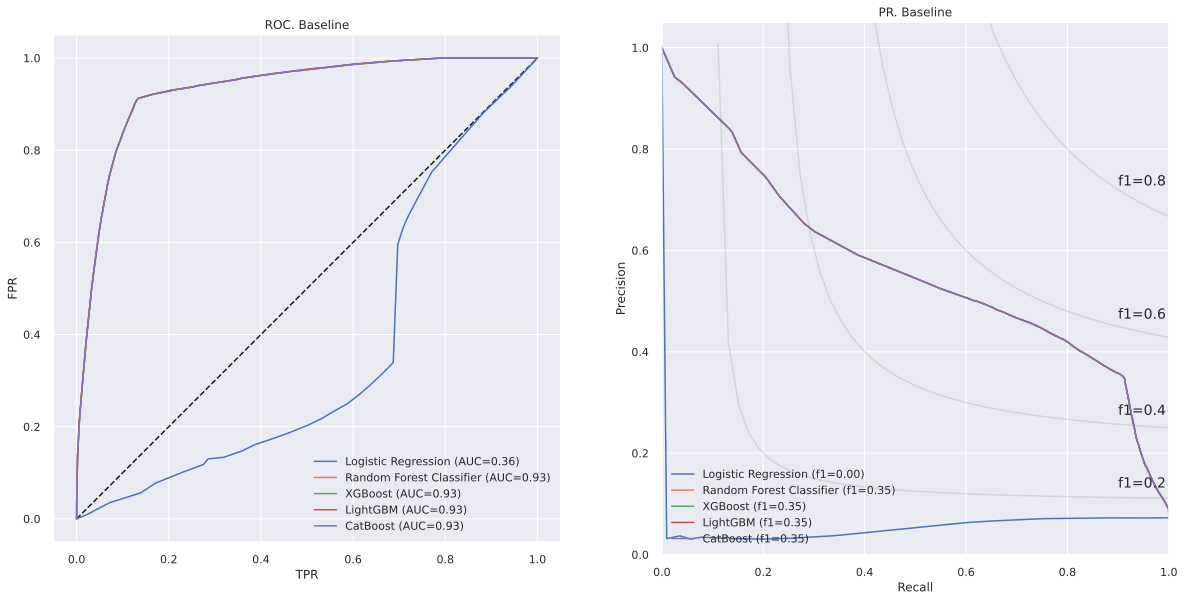

In [59]:
plot_roc_pr(models_list, X_train, y_train, X_test, y_test, title='Baseline')

### Отбор признаков<a class="anchor" id="feature_selection"></a>

In [60]:
X_train_prep = f_prep_pipeline.fit_transform(X_train)
X_train_prep.shape

(582157, 262)

In [61]:
X_test_prep = f_prep_pipeline.fit_transform(X_test)
X_test_prep.shape

(249496, 262)

In [62]:
model_lgbm = LGBMClassifier(random_state=RANDOM_STATE)
model_select = SelectFromModel(model_lgbm, threshold=1e-5)
X_train_prep = model_select.fit_transform(X_train_prep, y_train)
X_test_prep = model_select.transform(X_test_prep)

In [63]:
X_train_prep.shape

(582157, 203)

In [64]:
X_test_prep.shape

(249496, 203)

LGBMClassifier из SelectFromModel обнулила около 20% признаков.

### Балансировка классов<a class="anchor" id="classes_balancing"></a>

In [65]:
def get_f1(estimator, X_train, y_train, X_test, y_test):
    estimator.fit(X_train, y_train)
    train_pred = estimator.predict(X_train)
    test_pred = estimator.predict(X_test)
    train_f1 = f1_score(y_train, train_pred)
    test_f1 = f1_score(y_test, test_pred)
    return train_f1, test_f1 

In [66]:
n_sampling_strategy = [0, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55]

model_lgbm = LGBMClassifier(random_state=RANDOM_STATE)

smote_results = pd.DataFrame(columns=['train', 'test'], index=n_sampling_strategy)

smote_results.loc[0] = get_f1(model_lgbm, X_train_prep, y_train, X_test_prep, y_test)

for sampling_strategy in n_sampling_strategy[1:]:
    sm = SMOTE(sampling_strategy=sampling_strategy, random_state=RANDOM_STATE)
    X_train_balanced, y_train_balanced = sm.fit_resample(X_train_prep, y_train)
    smote_results.loc[sampling_strategy] = get_f1(model_lgbm, X_train_balanced, y_train_balanced, X_test_prep, y_test)

In [67]:
print(X_train_prep.shape, y_train.shape)
print(X_train_balanced.shape, y_train_balanced.shape)

(582157, 203) (582157,)
(837072, 203) (837072,)


Text(0, 0.5, 'F1 score')

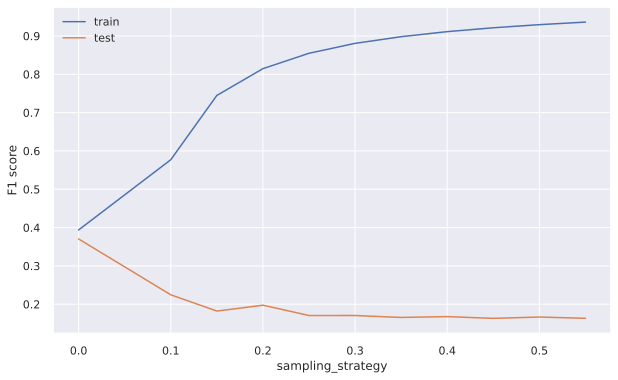

In [68]:
ax = smote_results.plot()
ax.set_xlabel('sampling_strategy')
ax.set_ylabel('F1 score')

In [69]:
rf_pipe = Pipeline([
                    ('ColumnSelector', ColumnSelector(f_ok)),
                    ('AddFeatures', AddFeatures(df_features)),
                    ('MemUseOptimizing', MemUseOptimizing()),
                    ('Feature Union', feature_union_pipeline),
                    ('SMOTE', SMOTE(sampling_strategy=0.15, random_state=RANDOM_STATE, n_jobs=-1)),
                    ('SelectFromModel', SelectFromModel(LGBMClassifier(random_state=RANDOM_STATE), threshold=1e-5)),
                    ('Random Forest', RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)),
])

xgb_pipe = Pipeline([
                    ('ColumnSelector', ColumnSelector(f_ok)),
                    ('AddFeatures', AddFeatures(df_features)),
                    ('MemUseOptimizing', MemUseOptimizing()),
                    ('Feature Union', feature_union_pipeline),
                    ('SMOTE', SMOTE(sampling_strategy=0.15, random_state=RANDOM_STATE, n_jobs=-1)),
                    ('SelectFromModel', SelectFromModel(LGBMClassifier(random_state=RANDOM_STATE), threshold=1e-5)),
                    ('XGBoost', XGBClassifier(random_state=RANDOM_STATE, n_jobs=-1)),
])

lgbm_pipe = Pipeline([
                    ('ColumnSelector', ColumnSelector(f_ok)),
                    ('AddFeatures', AddFeatures(df_features)),
                    ('MemUseOptimizing', MemUseOptimizing()),
                    ('Feature Union', feature_union_pipeline),
                    ('SMOTE', SMOTE(sampling_strategy=0.15, random_state=RANDOM_STATE, n_jobs=-1)),
                    ('SelectFromModel', SelectFromModel(LGBMClassifier(random_state=RANDOM_STATE), threshold=1e-5)),
                    ('LightGBM', LGBMClassifier(random_state=RANDOM_STATE)),
])

cat_pipe = Pipeline([
                    ('ColumnSelector', ColumnSelector(f_ok)),
                    ('AddFeatures', AddFeatures(df_features)),
                    ('MemUseOptimizing', MemUseOptimizing()),
                    ('Feature Union', feature_union_pipeline),
                    ('SMOTE', SMOTE(sampling_strategy=0.15, random_state=RANDOM_STATE, n_jobs=-1)),
                    ('SelectFromModel', SelectFromModel(LGBMClassifier(random_state=RANDOM_STATE), threshold=1e-5)),
                    ('LightGBM', LGBMClassifier(random_state=RANDOM_STATE)),
])

In [70]:
pipe_list = {
    'Logistic Regression': rf_pipe,
    'Random Forest Classifier': rf_pipe,
    'XGBoost': xgb_pipe,
    'LightGBM': lgbm_pipe,
    'CatBoost': cat_pipe,
}

### Обучение модели<a class="anchor" id="model_fit"></a>

In [71]:
%%time

for model_name, model in pipe_list.items():
    srart_t = time.time()
    print(f'Start fit {model_name}'.center(100,'*'))
    # model.fit(X_train, y_train)
    model.fit(X_train, y_train)
    print(f'End fit {model_name}, run time: {time_format(time.time()-start_t)}'.center(100,'*'))

***********************************Start fit Logistic Regression************************************
***********************End fit Logistic Regression, run time: 0:06:55.053739************************
*********************************Start fit Random Forest Classifier*********************************
*********************End fit Random Forest Classifier, run time: 0:09:17.116118*********************
*****************************************Start fit XGBoost******************************************
*****************************End fit XGBoost, run time: 0:12:02.399796******************************
*****************************************Start fit LightGBM*****************************************
*****************************End fit LightGBM, run time: 0:12:51.710189*****************************
*****************************************Start fit CatBoost*****************************************
*****************************End fit CatBoost, run time: 0:13:40.489154********************


********Logistic Regression. Balancing classes*******
TRAIN

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    540047
         1.0       1.00      1.00      1.00     42110

    accuracy                           1.00    582157
   macro avg       1.00      1.00      1.00    582157
weighted avg       1.00      1.00      1.00    582157

TEST

              precision    recall  f1-score   support

         0.0       0.94      0.99      0.96    231420
         1.0       0.60      0.24      0.34     18076

    accuracy                           0.93    249496
   macro avg       0.77      0.61      0.65    249496
weighted avg       0.92      0.93      0.92    249496



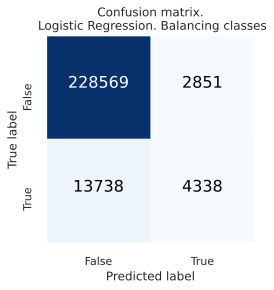

_____________________________________________________



*****Random Forest Classifier. Balancing classes*****
TRAIN

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    540047
         1.0       1.00      1.00      1.00     42110

    accuracy                           1.00    582157
   macro avg       1.00      1.00      1.00    582157
weighted avg       1.00      1.00      1.00    582157

TEST

              precision    recall  f1-score   support

         0.0       0.94      0.99      0.96    231420
         1.0       0.60      0.24      0.34     18076

    accuracy                           0.93    249496
   macro avg       0.77      0.61      0.65    249496
weighted avg       0.92      0.93      0.92    249496



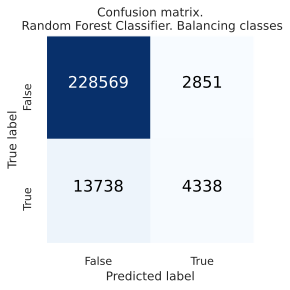

_____________________________________________________



**************XGBoost. Balancing classes*************
TRAIN

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97    540047
         1.0       0.71      0.39      0.50     42110

    accuracy                           0.94    582157
   macro avg       0.83      0.69      0.74    582157
weighted avg       0.94      0.94      0.94    582157

TEST

              precision    recall  f1-score   support

         0.0       0.95      0.98      0.97    231420
         1.0       0.61      0.32      0.42     18076

    accuracy                           0.94    249496
   macro avg       0.78      0.65      0.69    249496
weighted avg       0.92      0.94      0.93    249496



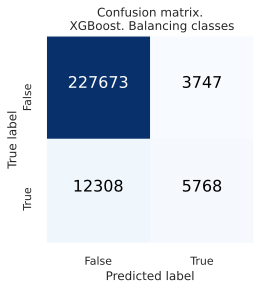

_____________________________________________________



*************LightGBM. Balancing classes*************
TRAIN

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97    540047
         1.0       0.67      0.32      0.43     42110

    accuracy                           0.94    582157
   macro avg       0.81      0.65      0.70    582157
weighted avg       0.93      0.94      0.93    582157

TEST

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97    231420
         1.0       0.63      0.30      0.41     18076

    accuracy                           0.94    249496
   macro avg       0.79      0.64      0.69    249496
weighted avg       0.92      0.94      0.93    249496



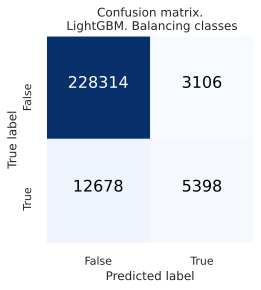

_____________________________________________________



*************CatBoost. Balancing classes*************
TRAIN

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97    540047
         1.0       0.67      0.32      0.43     42110

    accuracy                           0.94    582157
   macro avg       0.81      0.65      0.70    582157
weighted avg       0.93      0.94      0.93    582157

TEST

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97    231420
         1.0       0.63      0.30      0.41     18076

    accuracy                           0.94    249496
   macro avg       0.79      0.64      0.69    249496
weighted avg       0.92      0.94      0.93    249496



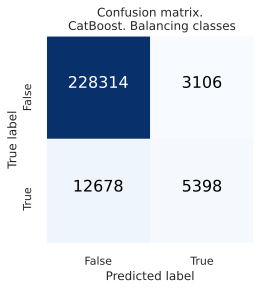

_____________________________________________________




In [72]:
get_classification_report(
                        pipe_list, 
                        X_train, y_train, X_test, y_test, 
                        classes=['False', 'True'], 
                        title='Balancing classes'
                             )

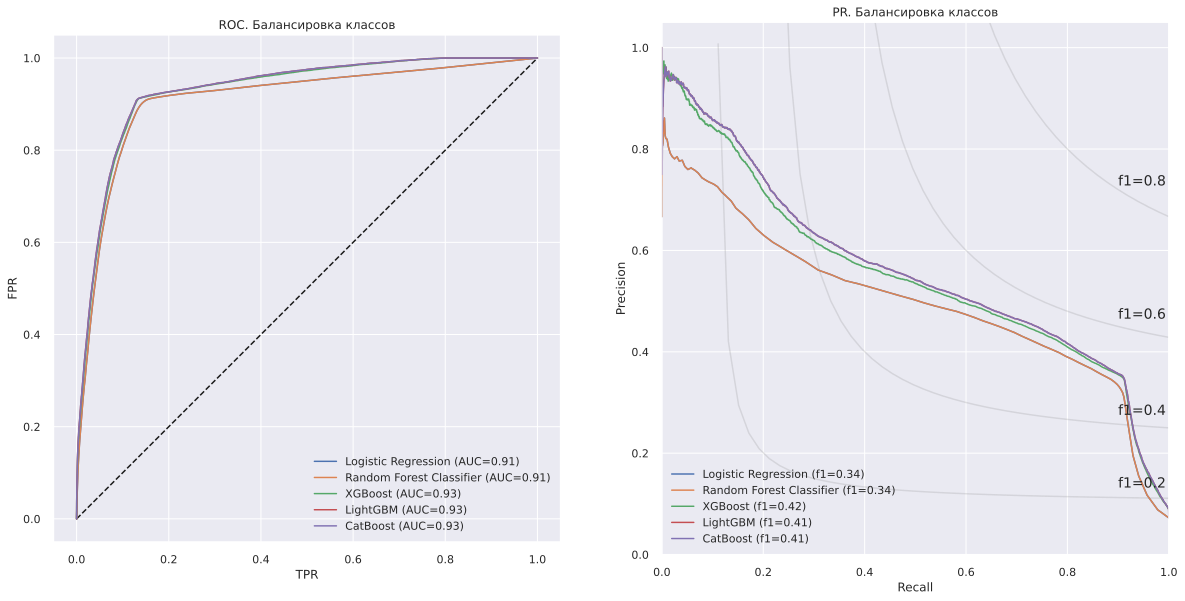

In [73]:
plot_roc_pr(pipe_list, X_train, y_train, X_test, y_test, title='Балансировка классов')

Хуже всех себя показали Logistic Regression и Random Forest Classifier. Остальные модели показали одинаковый результат.  XGBoost немного вырывается вперед, в зависимости от random_state.  
При прочих равных, остановлюсь на LigthGBM, т.к. она работает быстрее остальных

### Подбор гиперпараметров<a class="anchor" id="tuning_model"></a> 

#### Randomized Search

In [74]:
# cv=KFold(n_splits=3, random_state=RANDOM_STATE, shuffle=True)

In [75]:
# param_grid = {
#                 'SelectFromModel__threshold': [-np.inf, 1e-05],
#                 'LightGBM__class_weight': [None, 'balanced'],
#                 'LightGBM__learning_rate': np.arange(0.01, 1.0, 0.05),
#                 'LightGBM__max_depth': np.arange(3, 10, 1),
#                 'LightGBM__min_child_weight': np.arange(0.001, 1, 0.005),
#                 'LightGBM__n_estimators': np.arange(100, 500, 50),
#                 'LightGBM__num_leaves': np.arange(10, 50, 5),
#                 'LightGBM__reg_alpha': np.arange(0.0, 1.5, 0.05),
#                 'LightGBM__reg_lambda': np.arange(0.0, 1.0, 0.05),
#                 'LightGBM__subsample': np.arange(0.2, 1.0, 0.1),
# }

In [76]:
# %%time

# cv=KFold(n_splits=3, random_state=RANDOM_STATE, shuffle=True)
# grid = RandomizedSearchCV(lgbm_pipe, param_grid, scoring='f1', cv=cv)
# grid.fit(X_train, y_train)

In [77]:
# print(f'Best f1 score: {grid.best_score_:.2f}')

# print()
# print(f'Best parameters set found on development set:')
# print()
# print(grid.best_params_)

# print()
# print('Grid scores on development set:')
# print()

# for i, params in enumerate(grid.cv_results_['params']):
#     print(f'{grid.cv_results_["mean_test_score"][i]:0.3f} (+/-{grid.cv_results_["std_test_score"][i] * 2:0.03f})')

# print()

Best f1 score: 0.52

Best parameters set found on development set:

{'SelectFromModel__threshold': -inf, 'LightGBM__subsample': 0.7000000000000002, 'LightGBM__reg_lambda': 0.05, 'LightGBM__reg_alpha': 0.9500000000000001, 'LightGBM__num_leaves': 25, 'LightGBM__n_estimators': 350, 'LightGBM__min_child_weight': 0.9460000000000001, 'LightGBM__max_depth': 6, 'LightGBM__learning_rate': 0.21000000000000002, 'LightGBM__class_weight': 'balanced'}

Grid scores on development set:

0.416 (+/-0.001)
0.318 (+/-0.015)
0.424 (+/-0.002)
0.426 (+/-0.004)
0.521 (+/-0.003)
0.424 (+/-0.013)
0.515 (+/-0.003)
0.490 (+/-0.003)
0.510 (+/-0.005)
0.422 (+/-0.005)


### Построение финальной модели<a class="anchor" id="final_model"></a>

In [78]:
model_parameters = {
            'SelectFromModel__threshold': 1e-05, 
            'LightGBM__subsample': 0.70, 
            'LightGBM__reg_lambda': 0.05, 
            'LightGBM__reg_alpha': 0.95, 
            'LightGBM__num_leaves': 25, 
            'LightGBM__n_estimators': 350, 
            'LightGBM__min_child_weight': 0.946, 
            'LightGBM__max_depth': 6, 
            'LightGBM__learning_rate': 0.21, 
            'LightGBM__class_weight': 'balanced'
}

In [79]:
final_pipe = Pipeline([
                    ('ColumnSelector', ColumnSelector(f_ok)),
                    ('AddFeatures', AddFeatures(df_features)),
                    ('MemUseOptimizing', MemUseOptimizing()),
                    ('Feature Union', feature_union_pipeline),
                    ('SMOTE', SMOTE(sampling_strategy=0.15, random_state=RANDOM_STATE, n_jobs=-1)),
                    ('SelectFromModel', SelectFromModel(LGBMClassifier(random_state=RANDOM_STATE))),
                    ('LightGBM', LGBMClassifier(random_state=RANDOM_STATE)),
])

In [80]:
final_pipe.set_params(**model_parameters);

In [81]:
final_pipe.fit(X_train, y_train);


****************LightGBM. Final model****************
TRAIN

              precision    recall  f1-score   support

         0.0       0.99      0.89      0.94    540047
         1.0       0.40      0.91      0.55     42110

    accuracy                           0.89    582157
   macro avg       0.70      0.90      0.75    582157
weighted avg       0.95      0.89      0.91    582157

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.89      0.93    231420
         1.0       0.37      0.86      0.52     18076

    accuracy                           0.88    249496
   macro avg       0.68      0.87      0.73    249496
weighted avg       0.94      0.88      0.90    249496



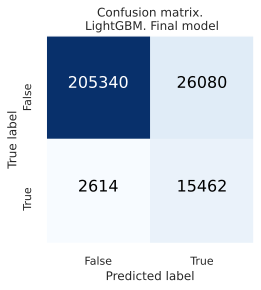

_____________________________________________________




In [82]:
get_classification_report(
                        {'LightGBM': final_pipe}, 
                        X_train, y_train, X_test, y_test, 
                        classes=['False', 'True'], 
                        title='Final model'
)

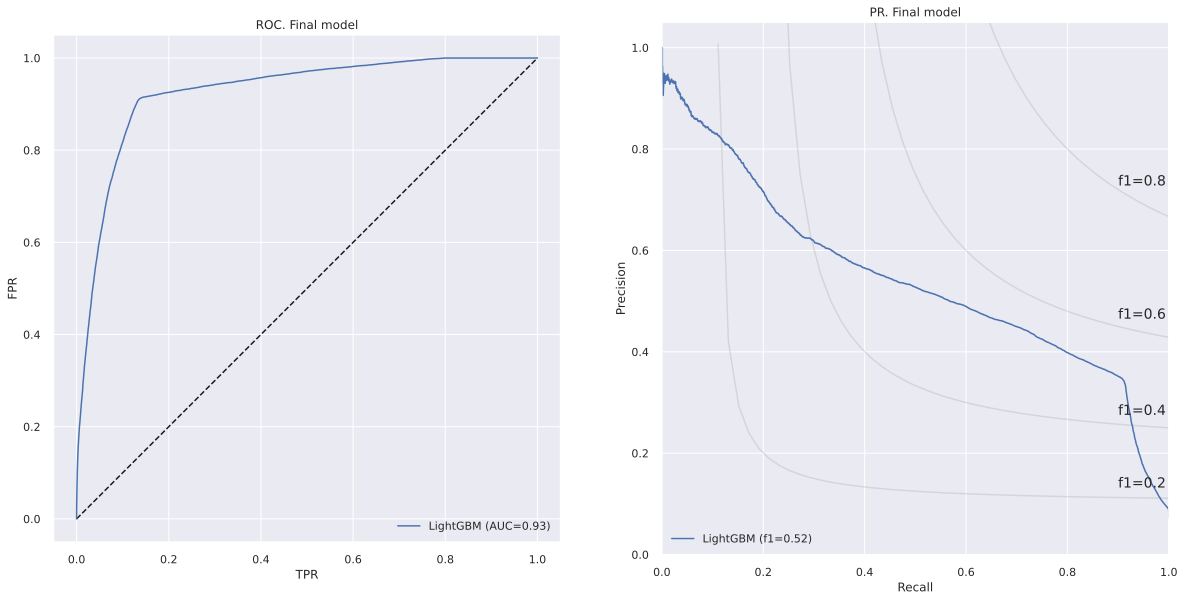

In [83]:
plot_roc_pr({'LightGBM': final_pipe}, X_train, y_train, X_test, y_test, title='Final model')

### Выбор порога вероятности для определения класса<a class="anchor" id="threshold_calibration"></a>

In [84]:
y_test_pred_probs = final_pipe.predict_proba(X_test)

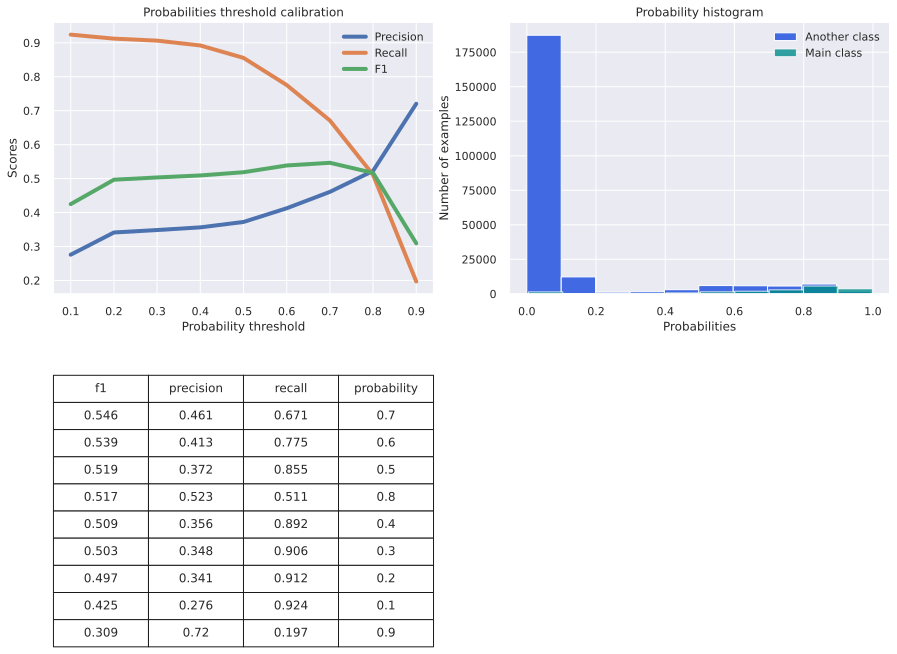

In [85]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)


****LightGBM. Final model. Probability threshold.****
TRAIN

              precision    recall  f1-score   support

         0.0       0.98      0.95      0.96    540047
         1.0       0.52      0.76      0.62     42110

    accuracy                           0.93    582157
   macro avg       0.75      0.85      0.79    582157
weighted avg       0.95      0.93      0.94    582157

TEST

              precision    recall  f1-score   support

         0.0       0.97      0.94      0.96    231420
         1.0       0.46      0.67      0.55     18076

    accuracy                           0.92    249496
   macro avg       0.72      0.80      0.75    249496
weighted avg       0.94      0.92      0.93    249496



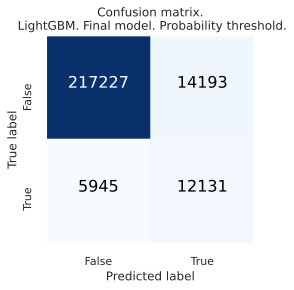

_____________________________________________________




In [86]:
get_classification_report(
                        {'LightGBM': final_pipe}, 
                        X_train, y_train, X_test, y_test, 
                        classes=['False', 'True'], 
                        title='Final model. Probability threshold.',
                        threshold=0.7
)

### Сравнение моделей<a class="anchor" id="comparison_of_models"></a>

In [87]:
model_list_final = {
                'LightGBM. Baseline': LGBMClassifier(random_state=RANDOM_STATE),
                'LightGBM. Final model': final_pipe
}

In [88]:
for model_name, model in model_list_final.items():
    start_t = time.time()
    print(f'Start fit {model_name}'.center(100,'*'))
    model.fit(X_train, y_train)
    print(f'End fit {model_name}, run time: {time_format(time.time()-start_t)}'.center(100,'*'))
    print()

************************************Start fit LightGBM. Baseline************************************
************************End fit LightGBM. Baseline, run time: 0:00:00.746457************************

**********************************Start fit LightGBM. Final model***********************************
**********************End fit LightGBM. Final model, run time: 0:00:58.485346***********************



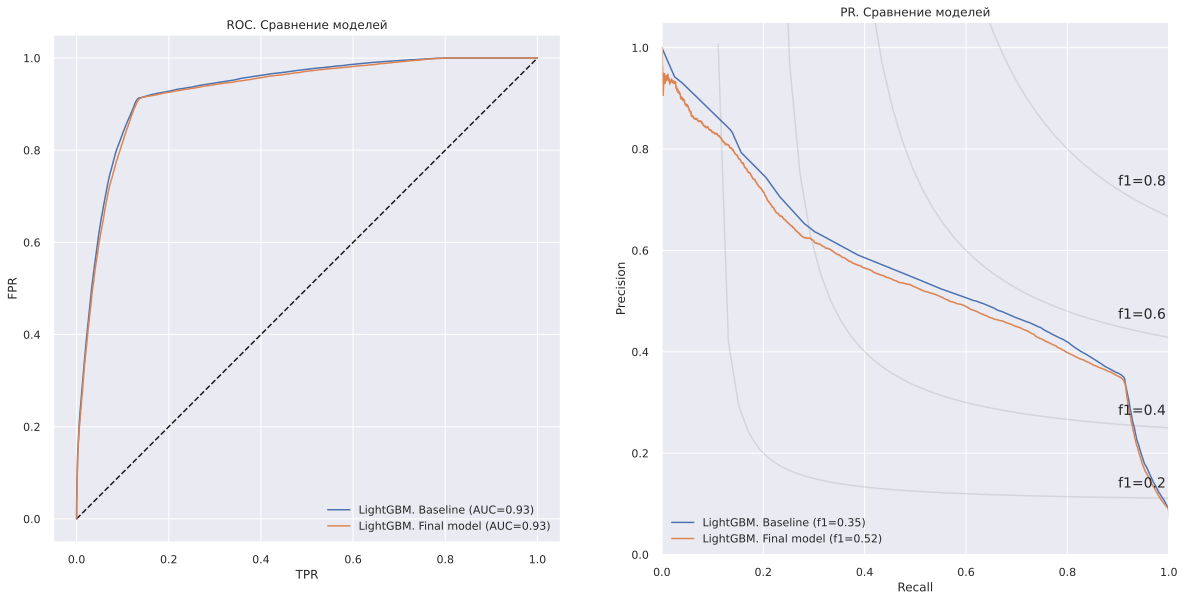

In [89]:
plot_roc_pr(model_list_final, X_train, y_train, X_test, y_test, title='Сравнение моделей')

### Сохранение финальной модели<a class="anchor" id="final_model_saving"></a>

In [90]:
with open(MODEL_FILE_PATH, 'wb') as f:
    pickle.dump(final_pipe, f)

## Прогнозирование на тестовом датасете<a class="anchor" id="forecasting"></a>

In [91]:
with open(MODEL_FILE_PATH, 'rb') as f:
    model = pickle.load(f)

In [92]:
df_test = pd.read_csv(TEST_DATASET_PATH, index_col=[1]).drop('Unnamed: 0', axis=1)
df_test.head()

,vas_id,buy_time
id,,
3130519,2.000,1548018000
2000860,4.000,1548018000
1099444,2.000,1546808400
1343255,5.000,1547413200
1277040,2.000,1546808400


In [93]:
df_test[TARGET] = model.predict_proba(df_test)[:, 1]

In [94]:
df_test

,vas_id,buy_time,target
id,,,
3130519,2.000,1548018000,0.160
2000860,4.000,1548018000,0.795
1099444,2.000,1546808400,0.105
1343255,5.000,1547413200,0.076
1277040,2.000,1546808400,0.081
...,...,...,...
2502453,5.000,1548018000,0.245
1693213,2.000,1548018000,0.188
1891350,2.000,1548018000,0.194


**Сохранение результатов**

In [95]:
df_test.to_csv(SUBMISSION_PATH)